# How does the memorability of a movie evolve regarding his characteristics (gender of producer, gender of actors, genre of movies, ratings, etc.) ?

For question 2, we need to identify citations in quotebank for specific movies.

In [1]:
import pandas as pd
import numpy as np
import json
import bz2
import pickle
from datetime import datetime, date

In [64]:
def parse_date(date):
    try:
        if not isinstance(date, str):
            return np.NaN
        elif len(date)%21 != 0:
            return np.NaN
        elif date == 'None' or date[0] == '-':
            return np.NaN
        elif '+0000-00-00T00:00:00Z' in date[0:21] :
            return '01.01.0001'
        elif '-00-00T00:00:00' in date[0:21] :
            return datetime.strptime(date[0:21], '+%Y-00-00T00:00:00Z').strftime('%d.%m.%Y')
        elif '-00T00:00:00' in date[0:21] :
            return datetime.strptime(date[0:21], '+%Y-%m-00T00:00:00Z').strftime('%d.%m.%Y')
        elif '+1939-02-29T00:00:00Z' in date:
            return '28.02.1939'
        else :
            return datetime.strptime(date[0:21], '+%Y-%m-%dT%H:%M:%SZ').strftime('%d.%m.%Y')
    except ValueError as e:
        if str(e) == 'day is out of range for month':
            return datetime.strptime(date[0:8], '+%Y-%m').strftime('%d.%m.%Y')
        else:
            print(date)
            raise e

## Task 1 
Load quotebank dataset previously filtered

In [40]:
path_to_file = '../generated/QUOTEBANK/moviefiltered_10tk_random.json.bz2'
path_to_out = '../temp/QUOTEBANK/moviefiltered_10tk_random_clean.json.bz2'

with bz2.open(path_to_file, 'rb') as in_file:
    with bz2.open(path_to_out, 'wb') as out_file:
        for instance in in_file:
            instance = json.loads(instance)
            instance.pop('quotation', None)
            instance.pop('speaker', None)
            instance.pop('phase', None)
            instance.pop('phase', None)
            instance['date'] = datetime.strptime(instance['date'][0:10], '%Y-%m-%d').strftime('%d.%m.%Y')
            date_quote = datetime.strptime(instance['date'], '%d.%m.%Y')
            date_film = datetime.strptime(instance['release_date'], '%d.%m.%Y')
            days = (date_quote - date_film).days
            instance['days'] = days
            out_file.write((json.dumps(instance)+'\n').encode('utf-8'))   

In [ ]:
movie_filtered_clean = pd.read_json(path_to_out, lines=True, compression='bz2')

In [ ]:
with open('generated/moviefiltered_10tk_random_clean_json.pickle', 'wb') as f: 
    pickle.dump(moviefiltered_clean, f)

In [ ]:
path = '../generated/QUOTEBANK/moviefiltered_10tk_random_clean.json.bz2'
film = {}

with bz2.open(path, 'rb') as f:  
    for instance in f:
        instance = json.loads(instance)
        if instance['film'] in film.keys():
            film[instance['film']] +=1
        else : 
            film[instance['film']] = 1

print(json.dumps(film, indent = 4))

In [48]:
df_films = pd.DataFrame(list(film.items()),columns = ['Name','occ'])
df_films['occ'].sum()

23084027

In [43]:
with open('../generated/QUOTEBANK/df_occ_films.pickle', 'rb') as f: 
    df_films = pickle.loads(f.read())
df_films.sort_values(by = 'occ', ascending = False)

,Name,occ
0,90,13160
1,América,21
2,10,83077
3,I,4600856
4,Johari,58
...,...,...
46433,Age_of_Innocence,1
46434,Drunken_Sailor,1
46435,No_Place_to_Go,1
46436,Redneck_Christmas,1


# Filtre films

In [44]:
df_films_filtred = df_films.sort_values(by = 'occ', ascending = False)
df_films_filtred.reset_index(drop = True, inplace = True)

On recherche le meilleur film de 2018 --> c'est Avengers Infinity War

Avengers Infinity War : 133 occurences.
Mais Venom, qui est un film très cool, est à 411.  

Donc on dégage tout ce qui est au dessus de 411.

In [45]:
upper_bound = 1068
df_films_filtred = df_films_filtred[(df_films_filtred['occ'] <= upper_bound) | (df_films_filtred['occ'].isna())]
df_films_filtred['occ'].sum()

2084416

In [46]:
df_films_filtred.head(45)

,Name,occ
1400,Black_Panther,1068
1401,Leon,1065
1402,Sex,1064
1403,Rising,1061
1404,Ready,1061
1405,Voice,1058
1406,Karl,1052
1407,Dog,1051
1408,Bird,1051
1409,Partners,1051


array([[<AxesSubplot:title={'center':'occ'}>]], dtype=object)

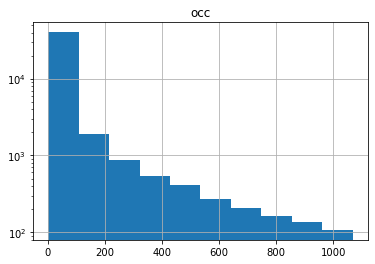

In [47]:
df_films_filtred.hist(log = True)

In [48]:
good_films = list(df_films_filtred['Name'])

In [54]:
with open('../generated/QUOTEBANK/list_filtred_films.pickle', 'wb') as f: 
    pickle.dump(good_films, f)

In [55]:
with open('../generated/QUOTEBANK/list_filtred_films.pickle', 'rb') as f: 
    good_films = pickle.loads(f.read())
good_films[:5]

['Black_Panther', 'Leon', 'Sex', 'Rising', 'Ready']

In [ ]:
path_to_file = '../generated/QUOTEBANK/moviefiltered_10tk_clean.json.bz2'
path_to_out = '../temp/QUOTEBANK/movie_10tk_FILTERED.json.bz2'

with bz2.open(path_to_file, 'rb') as in_file:
    with bz2.open(path_to_out, 'wb') as out_file:
        for instance in in_file:
            instance = json.loads(instance)
            if instance['film'].replace('_', ' ') in good_films:
                out_file.write((json.dumps(instance)+'\n').encode('utf-8'))    

In [72]:
moviefiltered_clean = pd.read_json('../generated/QUOTEBANK/movie_10tk_FILTERED.json.bz2', lines = True, compression='bz2')
moviefiltered_clean

,quoteID,date,numOccurrences,gender,dob,film,id_film,gender_pct,release_date,days
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,0.790548,3.7.2017,280
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582,0.000000,6.9.2017,288
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323,0.664816,14.10.2017,250
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624,0.687913,21.2.2017,419
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474,0.000000,13.5.2017,338
...,...,...,...,...,...,...,...,...,...,...
1800406,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,0.000000,14.6.2017,207
1800407,2018-04-10-152991,2018-10-04,2,male,None,Warcraft,tt0803096,0.509333,7.5.2017,338
1800408,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792,0.212152,25.8.2017,478
1800409,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436,0.375707,17.7.2017,184


In [73]:
moviefiltered_clean.drop(columns=['gender_pct','release_date', 'days'], inplace = True)

## Task 2
Find movies name in quotebank whith a loop. Use column movie name in IMDb and research them to quotation. Then filter the movies with few citations and if two movies are in the same citation keep both films.

In [74]:
moviefiltered_clean

,quoteID,date,numOccurrences,gender,dob,film,id_film
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474
...,...,...,...,...,...,...,...
1800406,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508
1800407,2018-04-10-152991,2018-10-04,2,male,None,Warcraft,tt0803096
1800408,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792
1800409,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436


## Task 3 
For this task, add column of interest in the dataset : 
- release date
- gender perc
- ratings

To assign the gender, we decides that if more than 50% of actors are female, in concequence global gender is female. 

In [75]:
#format publicy_date from Wikidata to enrich data set
tconst_release_date = pd.read_json('../generated/QUOTEBANK/tconst_enriched_dict.json.bz2', 
                                   lines = True, 
                                   compression='bz2')


In [76]:
tconst_release_date['publicy_date'] = tconst_release_date['publicy_date'].map(parse_date)
tconst_release_date.rename(columns={'tconst' : 'id_film'}, inplace = True)
tconst_release_date.head()

,id_film,publicy_place,publicy_date
0,tt1675434,Q30,25.05.2012
1,tt0050083,Q30,10.04.1957
2,tt4168940,Unknown,14.01.1989
3,tt0074486,Unknown,01.01.1977
4,tt0056801,Unknown,14.02.1963


In [191]:
moviefiltered_enriched = pd.merge(moviefiltered_clean, tconst_release_date, on = 'id_film', how = 'left')

In [192]:
moviefiltered_enriched

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_place,publicy_date
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,Unknown,01.01.2011
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582,NaN,NaN
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323,NaN,NaN
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624,NaN,NaN
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1800830,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,Unknown,01.01.2021
1800831,2018-04-10-152991,2018-10-04,2,male,None,Warcraft,tt0803096,Unknown,01.06.2016
1800832,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792,NaN,NaN
1800833,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436,NaN,NaN


In [193]:
moviefiltered_enriched.drop(columns = ['publicy_place'])

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_date
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,01.01.2011
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582,NaN
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323,NaN
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624,NaN
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474,NaN
...,...,...,...,...,...,...,...,...
1800830,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,01.01.2021
1800831,2018-04-10-152991,2018-10-04,2,male,None,Warcraft,tt0803096,01.06.2016
1800832,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792,NaN
1800833,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436,NaN


In [194]:
date_nan = moviefiltered_enriched[moviefiltered_enriched['publicy_date'].isna()]
print(f'{len(date_nan)} publicy date are missing')

1372191 publicy date are missing


In [195]:
display(date_nan)

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_place,publicy_date
1,2018-06-21-000076,2018-06-21,1,male,None,Johari,tt0353582,NaN,NaN
2,2018-06-21-000076,2018-06-21,1,male,None,Abang,tt0080323,NaN,NaN
3,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Clock,tt14409624,NaN,NaN
4,2018-04-16-000822,2018-04-16,3,male,28.02.1968,Escape,tt8256474,NaN,NaN
5,2018-12-14-001047,2018-12-14,1,male,15.01.1986,365,tt7972454,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1800828,2018-07-27-118690,2018-07-27,3,male,22.09.1991,Yanga,tt1638908,NaN,NaN
1800829,2018-10-20-074854,2018-10-20,2,male,28.05.1971,Castro,tt3248890,NaN,NaN
1800832,2018-12-16-061919,2018-12-16,21,male,01.01.2000,Strip,tt2107792,NaN,NaN
1800833,2018-01-17-155997,2018-01-17,1,male,27.04.1969,Durbin,tt6351436,NaN,NaN


In [196]:
films_not_important = date_nan.groupby('film').count().sort_values(by = 'id_film', ascending=0)
#films_not_important = list(films_not_important.index)

In [197]:
films_not_important

,quoteID,date,numOccurrences,gender,dob,id_film,publicy_place,publicy_date
film,,,,,,,,
Sex,1064,1064,1064,1064,901,1064,0,0
Rising,1061,1061,1061,1061,864,1061,0,0
Voice,1058,1058,1058,1058,895,1058,0,0
Karl,1052,1052,1052,1052,916,1052,0,0
Bird,1051,1051,1051,1051,937,1051,0,0
...,...,...,...,...,...,...,...,...
Kram,1,1,1,1,1,1,0,0
Tahsildar,1,1,1,1,1,1,0,0
Tailenders,1,1,1,1,1,1,0,0


__Discuss__ : Here we see the films that do not have a known release date in Wikidata. That is, they don't have a Wikipedia page. So it's assumed that these aren't important movies, so people don't talk about them as often as stated here (these are false positives). This is why we decide not to take them into account. 

In [198]:
#delete films without publicy_date
moviefiltered_enriched = moviefiltered_enriched[moviefiltered_enriched['publicy_date'].notna()]
moviefiltered_enriched.drop(columns='publicy_place', inplace = True)
moviefiltered_enriched.head()

/Users/Tupin/opt/anaconda3/envs/ada/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_date
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,01.01.2011
8,2018-05-20-000976,2018-05-20,2,female,15.03.1993,Raazi,tt7098658,11.05.2018
9,2018-11-12-002175,2018-12-11,1,male,01.01.1979,X.,tt6190456,01.11.2018
21,2018-03-13-004134,2018-03-13,1,male,None,Ranveer,tt9430574,01.02.2019
25,2018-01-22-003803,2018-01-22,4,female,25.04.1998,Bando,tt8850222,12.08.2020


In [199]:
tconst_usefull = list(moviefiltered_enriched['id_film'])

with open('../generated/tconst_usefull_list.pickle', 'wb') as f: 
    pickle.dump(tconst_usefull, f)

In [186]:
with open('../generated/tconst_usefull_list.pickle', 'rb') as f: 
    tconst_usefull = pickle.loads(f.read())

## Task 4
Plots the distributions of memorability of the movies regarding the characteristics added,analyze them and conclude question 2. The time correspond to the timestamps of the citation.   


In [171]:
#calculate column 'days', which is the number of day between release date and quote date

In [200]:
df_datetime = moviefiltered_enriched.copy()

In [206]:
df_datetime['date'] = pd.to_datetime(df_datetime['date'], format = '%Y-%m-%d')
df_datetime['publicy_date'] = pd.to_datetime(df_datetime['publicy_date'], format = '%d.%m.%Y')

df_datetime['days'] = (df_datetime['date'] - df_datetime['publicy_date'])
df_datetime['days'] = df_datetime['days'].map(lambda x : x.days)
df_datetime

,quoteID,date,numOccurrences,gender,dob,film,id_film,publicy_date,days
0,2018-04-09-000057,2018-09-04,1,male,18.04.1979,América,tt1670931,2011-01-01,2803
8,2018-05-20-000976,2018-05-20,2,female,15.03.1993,Raazi,tt7098658,2018-05-11,9
9,2018-11-12-002175,2018-12-11,1,male,01.01.1979,X.,tt6190456,2018-11-01,40
21,2018-03-13-004134,2018-03-13,1,male,None,Ranveer,tt9430574,2019-02-01,-325
25,2018-01-22-003803,2018-01-22,4,female,25.04.1998,Bando,tt8850222,2020-08-12,-933
...,...,...,...,...,...,...,...,...,...
1800820,2018-06-06-133240,2018-06-06,1,male,21.09.1950,Pollock,tt0183659,2000-01-01,6731
1800822,2018-10-14-072113,2018-10-14,1,female,07.12.1979,Gen,tt0782042,2006-01-01,4669
1800827,2018-09-22-069732,2018-09-22,2,other,None,Wrong,tt1901040,2012-10-04,2179
1800830,2018-01-07-072026,2018-07-01,1,male,17.03.1951,Cherry,tt9130508,2021-01-01,-915


In [207]:
df_datetime['days_mean'] = df_datetime['days'].apply(lambda x : x if x >= 0 else np.NaN)
df_datetime['days_max'] = df_datetime['days'].apply(lambda x : x if x >= 0 else np.NaN)
df_datetime['nb_quote_month'] = df_datetime['days'].apply(lambda x : 1 if 0 <= x <= 28 else 0)

df_datetime['days_mean_before'] = df_datetime['days'].apply(lambda x : x if x <= 0 else np.NaN)
df_datetime['days_max_before'] = df_datetime['days'].apply(lambda x : x if x <= 0 else np.NaN)
df_datetime['nb_quote_month_before'] = df_datetime['days'].apply(lambda x : 1 if -28 <= x < 0 else 0)

In [220]:
agg_func_dict = {}
agg_func_dict['quoteID'] = lambda x : abs(x.count())
agg_func_dict['days_mean'] = lambda x : abs(x.mean())
agg_func_dict['days_mean_norm'] = lambda x : abs(x.mean())
agg_func_dict['days_max'] = lambda x : abs(x.max())
agg_func_dict['nb_quote_month'] = lambda x : x.sum()
agg_func_dict['days_mean_before'] = lambda x : abs(x.mean())
agg_func_dict['days_mean_norm_before'] = lambda x : abs(x.mean())
agg_func_dict['days_max_before'] = lambda x : abs(x.min())
agg_func_dict['nb_quote_month_before'] = lambda x : x.sum()
#print(json.dumps(agg_func_dict, indent = 2))

In [221]:
days_mean_global_min = df_datetime['days_mean'].min()
days_mean_global_max = df_datetime['days_mean'].max()

days_mean_before_global_min = df_datetime['days_mean_before'].min()
days_mean_before_global_max = df_datetime['days_mean_before'].max()

In [222]:
df_datetime['days_mean_norm'] = (df_datetime['days_mean'] - days_mean_global_min) / (days_mean_global_max - days_mean_global_min)
df_datetime['days_mean_norm_before'] = abs((df_datetime['days_mean_before'] - days_mean_global_min) / (days_mean_global_max - days_mean_global_min))

In [223]:
df_agg = df_datetime.groupby(['id_film', 'film']).agg(agg_func_dict)
df_agg

,,quoteID,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before
id_film,film,,,,,,,,,
tt0002833,Evinrude,9,38160.666667,0.976476,38273.0,0,NaN,NaN,NaN,0
tt0003631,Aristocracy,7,38188.571429,0.977190,38328.0,0,NaN,NaN,NaN,0
tt0004134,Hypocrites,3,37790.333333,0.966999,37970.0,0,NaN,NaN,NaN,0
tt0004963,Beulah,16,37763.375000,0.966309,37972.0,0,NaN,NaN,NaN,0
tt0005190,Destruction,111,37804.675676,0.967366,37984.0,0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...
tt9894450,Felicità,1,NaN,NaN,NaN,0,574.000000,0.014688,574.0,0
tt9894470,VFW,146,NaN,NaN,NaN,0,594.061644,0.015201,773.0,0
tt9900782,Kaithi,1,NaN,NaN,NaN,0,472.000000,0.012078,472.0,0


In [224]:
days_max_global_min = df_agg['days_max'].min()
days_max_global_max = df_agg['days_max'].max()
nb_quote_month_global_min = df_agg['nb_quote_month'].min()
nb_quote_month_global_max = df_agg['nb_quote_month'].max()

days_max_global_min_before = df_agg['days_max_before'].min()
days_max_global_max_before = df_agg['days_max_before'].max()
nb_quote_month_global_min_before = df_agg['nb_quote_month_before'].min()
nb_quote_month_global_max_before = df_agg['nb_quote_month_before'].max()

In [225]:
df_agg['days_max_norm'] = (df_agg['days_max'] - days_max_global_min) / (days_max_global_max - days_max_global_min)
df_agg['nb_quote_month_norm'] = (df_agg['nb_quote_month'] - nb_quote_month_global_min) / (nb_quote_month_global_max - nb_quote_month_global_min)
df_agg['days_max_norm_before'] = (df_agg['days_max_before'] - days_max_global_min_before) / (days_max_global_max_before - days_max_global_min_before)
df_agg['nb_quote_month_norm_before'] = (df_agg['nb_quote_month_before'] - nb_quote_month_global_min_before) / (nb_quote_month_global_max_before - nb_quote_month_global_min_before)

In [226]:
df_agg['memorability'] = 0.3*df_agg['days_mean_norm'] + 0.1*df_agg['days_max_norm'] + 0.6*df_agg['nb_quote_month_norm']

In [228]:
df_agg.reset_index()

,id_film,film,quoteID,days_mean,days_mean_norm,days_max,nb_quote_month,days_mean_before,days_mean_norm_before,days_max_before,nb_quote_month_before,days_max_norm,nb_quote_month_norm,days_max_norm_before,nb_quote_month_norm_before,memorability
0,tt0002833,Evinrude,9,38160.666667,0.976476,38273.0,0,NaN,NaN,NaN,0,0.979350,0.0,NaN,0.0,0.390878
1,tt0003631,Aristocracy,7,38188.571429,0.977190,38328.0,0,NaN,NaN,NaN,0,0.980757,0.0,NaN,0.0,0.391233
2,tt0004134,Hypocrites,3,37790.333333,0.966999,37970.0,0,NaN,NaN,NaN,0,0.971597,0.0,NaN,0.0,0.387259
3,tt0004963,Beulah,16,37763.375000,0.966309,37972.0,0,NaN,NaN,NaN,0,0.971648,0.0,NaN,0.0,0.387058
4,tt0005190,Destruction,111,37804.675676,0.967366,37984.0,0,NaN,NaN,NaN,0,0.971955,0.0,NaN,0.0,0.387405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6578,tt9894450,Felicità,1,NaN,NaN,NaN,0,574.000000,0.014688,574.0,0,NaN,0.0,0.312296,0.0,NaN
6579,tt9894470,VFW,146,NaN,NaN,NaN,0,594.061644,0.015201,773.0,0,NaN,0.0,0.420566,0.0,NaN
6580,tt9900782,Kaithi,1,NaN,NaN,NaN,0,472.000000,0.012078,472.0,0,NaN,0.0,0.256801,0.0,NaN
6581,tt9902160,Herself,15,NaN,NaN,NaN,0,537.200000,0.013746,685.0,0,NaN,0.0,0.372688,0.0,NaN
